## Building adversarial examples.

__This notebook is inspired by the https://github.com/dangeng/Simple_Adversarial_Examples repo and [PyTorch tutorial on Spatial Transformer](https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html).__

Adversarial examples are inputs to a neural network that are designed to "trick" the neural network. For example, [here](https://blog.openai.com/robust-adversarial-inputs/) is a cool project that an intern at OpenAI did on adversarial examples. They managed "convince" an image recognition neural network that a picture of a cat was a desktop computer. Adversarial examples are incredibly important when it comes to the security of neural network models and is currently a very active field of research (for example, a [paper](https://arxiv.org/pdf/1611.02770.pdf) from Berkeley's own Dawn Song).

In [1]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
from torchvision import datasets, transforms

We are using MNIST dataset for our experiments, while the approach we discuss can be applied to almost all types of datasets.

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=2)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=2)

In [4]:
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.autograd.gradcheck import zero_gradients

In [5]:
# a special module that converts [batch, channel, w, h] to [batch, units]: tf/keras style
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

### 1. Train the network on MNIST.

In [ ]:
Create network of structure
* Conv2d 32 kernels of size 5x5
* ReLU
* MaxPooling with kernel 2x2
* Conv2d 64 kernels of size 5x5
* ReLU
* MaxPooling with kernel 2x2
* Conv2d 128 kernels of size 3x3
* Flatten
* Linear layer to the logits (no actication function)

In [6]:
model = nn.Sequential()
# your code here

Let's test it

In [7]:
(data, target) = next(iter(train_loader))
output = model(data)

In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure STN the performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += loss_func(output, target).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [9]:
device = torch.device('cpu')
for epoch in range(2):
    train(epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.316141
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.147836
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.011666
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.052830


From now on we need our model only in eval mode.

In [10]:
model.eval()

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (a1): ReLU()
  (p1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (a2): ReLU()
  (p2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (a3): ReLU()
  (f1): Flatten()
  (l1): Linear(in_features=512, out_features=10, bias=True)
)

In [101]:
# with open('trained_MNIST_model', 'wb') as f:
#     torch.save({'state_dict': model.state_dict()}, f)

The next function allows us to see the network prediction along with logits it provides for each class.

In [554]:
def predict(model, example=None, loader=None):
    if example is None:
        if loader is not None:
            example = next(iter(loader))[0][:1]
    else:
        example = transforms.ToTensor()(example)
    print(example.dtype)
    prediction = model(example)
    print('Network output: \n' + str(np.round(prediction.detach().cpu().numpy(), 2)) + '\n')
    print('Network prediction: ' + str(prediction.argmax().numpy()) + '\n')
    print('Actual image: ')
    
    plt.imshow(example[0].cpu().numpy().reshape((28, 28)), cmap='Greys')

torch.float32
Network output: 
[[-14.38  -9.02  23.12  -8.76 -10.08 -18.62 -19.4   -2.16 -14.56  -9.79]]

Network prediction: 2

Actual image: 


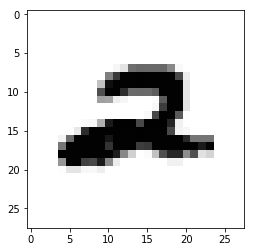

In [555]:
predict(model, loader=train_loader)

To actually generate adversarial examples we solve a minimization problem. We do this by setting a "goal" label called $ \vec y_{goal} $ (for instance, if we wanted the network to think the adversarial image is an 8, then we would choose $ \vec y_{goal} $ to be a one-hot vector with the eighth entry being 1). Now we define a cost function:

$$ C = \frac{1}{2} \|\vec y_{goal} - \hat y(\vec x)\|^2_2 $$

where $ \| \cdot \|^2_2 $ is the squared Euclidean norm and $ \hat y $ is the network's output. It is a function of $ \vec x $, the input image to the network, so we write $ \hat y(\vec x) $. Our goal is to find an $ \vec x $ such that $ C $ is minimized. Hopefully this makes sense, because if we find an image $ \vec x $ that minimizes $ C $ then that means the output of the network when given $ \vec x $ is close to our desired output, $ \vec y_{goal} $. So in full mathy language, our optimization problem is:

$$ \arg \min_{\vec x} C(\vec x) $$

that is, find the $ \vec x $ that minimizes the cost $ C $.

To actually do this we can do gradient descent on $ C $. Start with an initially random vector $ \vec x $ and take steps (changing $ \vec x $) gradually in the direction opposite of the gradient $ \nabla_x C $. To actually get these derivatives we can perform backpropagation on the network. In contrast to training a network, where we perform gradient descent on the weights and biases, when we create adversarial examples we hold the weights and biases constant (because we don't want to change the network!), and change the inputs to our network.

In [540]:
def adversarial(model, target, steps, eta):
    """
    model : network object
        neural network instance to use
    target: integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    """
    # Set the goal output
    goal = torch.LongTensor([target])


    # Create a random image to initialize gradient descent with
    mean, std = 0.1307, 0.3081
    x = torch.from_numpy(np.random.normal(mean, std, (1, 1, 28, 28)).astype(np.float32)).requires_grad_(True)

    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative

        # Your code here 
        
        zero_gradients(x)
        if i % 100 == 0:
            print('Loss:', loss.data)
        
    return x

# Wrapper function
def generate(model, target, steps, eta):
    """
    n : integer
        goal label (not a one hot vector)
    """
    a = adversarial(model, target, steps, eta)
    x = np.round(model(a).cpu().detach().numpy(), 2)
    image = a.cpu().detach().numpy()
    print('Network Output: \n' + str(x) + '\n')
    
    print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    
    print('Adversarial Example: ')
    plt.imshow(image.reshape(28,28), cmap='Greys')
    return a

Now let's generate some adversarial examples! Use the function provided to mess around with the neural network. (For some inputs gradient descent doesn't always converge; 0 and 5 seem to work pretty well though. I suspect convergence is very highly dependent on our choice of random initial $ \vec x $. We'll see later in the notebook if we force the adversarial example to "look like" a handwritten digit, convergence is much more likely. In a sense we will be adding regularization to our generation process).

Loss: tensor(2.8066)
Loss: tensor(0.3075)
Loss: tensor(0.0766)
Loss: tensor(0.0411)
Loss: tensor(0.0283)
Loss: tensor(0.0215)
Loss: tensor(0.0172)
Loss: tensor(0.0144)
Loss: tensor(0.0125)
Loss: tensor(0.0110)
Network Output: 
[[-3.29 -2.57 -1.52 -2.86 -3.82 -2.39  4.28 -4.23 -1.8  -3.68]]

Network Prediction: 6

Adversarial Example: 


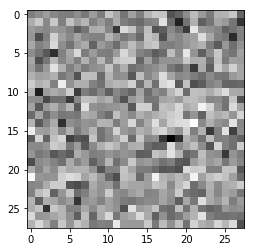

In [541]:
adv_example = generate(model, 6, 1000, 0.01)

Sweet! We've just managed to create an image that looks utterly meaningless to a human, but the neural network thinks is a '5' with very high certainty. We can actually take this a bit further. Let's generate an image that looks like one number, but the neural network is certain is another. To do this we will modify our cost function a bit. Instead of just optimizing the input image, $ \vec x $, to get a desired output label, we'll also optimize the input to look like a certain image, $ \vec x_{target} $, at the same time. Our new cost function will be

$$ C = \|\vec y_{goal} - y_{hat}(\vec x)\|^2_2 + \lambda \|\vec x - \vec x_{target}\|^2_2 $$

The added term tells us the distance from our $ \vec x $ and some $ \vec x_{target} $ (which is the image we want our adversarial example to look like). Because we want to minimize $ C $, we also want to minimize the distance between our adversarial example and this image. The $ \lambda $ is hyperparameter that we can tune; it determines which is more important: optimizing for the desired output or optimizing for an image that looks like $ \vec x_{target} $.

If you are familiar with ridge regularization, the above cost function might look suspiciously like the ridge regression cost function. In fact, we can view this generation method as giving our model a prior, centered on our target image.

Here is a function that implements optimizing the modified cost function, called `sneaky_adversarial` (because it is very sneaky). Note that the only difference between this function and `adversarial` is an additional term on the gradient descent update for the regularization term:

In [542]:
reg_loss = nn.MSELoss()
def sneaky_adversarial(model, target, x_target, steps, eta, lambd=0.05):
    """
    model : network object
        neural network instance to use
    target: integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    """
    # Set the goal output
    goal = torch.LongTensor([target])


    # Create a random image to initialize gradient descent with
#     mean, std = 0.1307, 0.3081
#     x = torch.from_numpy(np.random.normal(mean, std, (1, 1, 28, 28)).astype(np.float32)).requires_grad_(True)
    x = torch.zeros((1, 1, 28, 28), dtype=torch.float32) #- 0.42
    x.requires_grad_(True)
    target_max = x_target.data.max()
    target_min = x_target.data.min()
    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        loss = # Your code here
        
        # Your code here
        
        zero_gradients(x)

        if i % 100 == 0:
            print('Loss:', loss.data)
        
    return x


def _get_example(class_num, loader):
    batch = next(iter(loader))
    for _i in range(len(batch[0])):
        example = batch[0][_i:_i+1]
        if class_num == batch[1][_i]:
            return example

        
# Wrapper function
def sneaky_generate(model, target, steps, eta, lambd=0.05, class_num=None, loader=None, example=None):
    """
    target : integer
        goal label (not a one hot vector)
    """
    if example is not None:
        if not isinstance(example, torch.Tensor):
            try:
                example = transforms.ToTensor()(example)
            except Exception as exc:
                print('Failed to cast example to torch.Tensor')
                raise exc
    else:
        if loader is None or class_num is None:
            raise ValueError('Either class_num and loader or example should be passsed')
        else:
            example = _get_example(class_num, loader)
        
    a = sneaky_adversarial(model, target, example, steps, eta, lambd)
    x = np.round(F.softmax(model(a), dim=1).cpu().detach().numpy(), 2)
    image = a.cpu().detach().numpy()
    print('Network Predicted Probabilities: \n' + str(x) + '\n')
    
    print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    
    print('\nWhat we want our adversarial example to look like: ')
    plt.imshow(np.clip(example.cpu().detach().numpy().reshape((28,28)), image.min(), image.max()), cmap='Greys')
    plt.colorbar()
    plt.show()
    
    print('\n')

    
    print('Adversarial Example: ')
    plt.imshow(image.reshape(28,28), cmap='Greys')
    plt.colorbar()
    return a, example

In [543]:
c = _get_example(7, test_loader)

Loss: tensor(3.3243)
Loss: tensor(0.6038)
Loss: tensor(0.4367)
Loss: tensor(0.3360)
Loss: tensor(0.2744)
Loss: tensor(0.2399)
Loss: tensor(0.2162)
Loss: tensor(0.1933)
Loss: tensor(0.1797)
Loss: tensor(0.1709)
Network Predicted Probabilities: 
[[0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]

Network Prediction: 0


What we want our adversarial example to look like: 


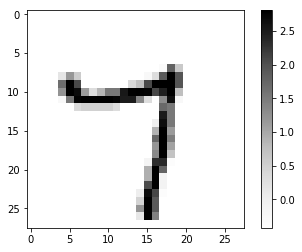



Adversarial Example: 


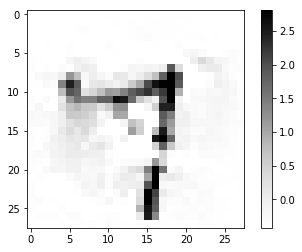

In [544]:
a, example = sneaky_generate(model, 0, 1000, 1., 1.5, example=c)

Loss: tensor(3.7718)
Loss: tensor(0.8400)
Loss: tensor(0.5160)
Loss: tensor(0.3582)
Loss: tensor(0.2859)
Loss: tensor(0.2534)
Loss: tensor(0.2352)
Loss: tensor(0.2187)
Loss: tensor(0.2056)
Loss: tensor(0.1970)
Network Predicted Probabilities: 
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.99]]

Network Prediction: 9


What we want our adversarial example to look like: 


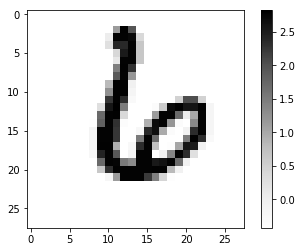



Adversarial Example: 


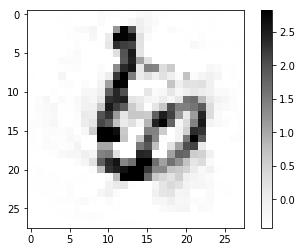

In [552]:
a, real = sneaky_generate(model, target=9, steps=1000, eta=1., lambd=1.5, class_num=6, loader=test_loader)

Play around with this function to make "sneaky" adversarial examples! (Again, some numbers converge better than others... try 0, 2, 3, 5, 6, or 8 as a target label. 1, 4, 7, and 9 still don't work as well... no idea why... We get more numbers that converge because we've added regularization term to our cost function. Perhaps changing $ \lambda $ will get more to converge?)